In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout, LayerNormalization, Attention, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



CODE to check if the Tensor Flow can see the GPU

In [3]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected by TensorFlow")

1 Physical GPUs, 1 Logical GPUs


List of Companies used in the dataset:

In [4]:
company_symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "SSNLF", "SONY", 
    "BBY", "COST", "WMT", "INTC", "AMD", "TXN", "QCOM", "AVGO", "T", 
    "VZ", "TMUS", "CSCO", "CRM", "ADBE", "ORCL", "NOW", "V", "MA", 
    "PYPL", "SQ", "TSLA", "GM", "F", "NIO", "RIVN", "JNJ", "PFE", 
    "MRNA", "GILD", "AMGN", "BA", "GE", "HON", "MMM", "CAT", "XOM", 
    "CVX", "NEE", "DUK", "SLB"
]

Load Data

In [5]:
df = pd.read_csv("data/AAPL.csv")
print(df.head())

   Unnamed: 0  1. open  2. high    3. low  4. close  5. volume
0  2024-06-04  194.635  195.320  193.0342    194.35   47471445
1  2024-06-03  192.900  194.990  192.5200    194.03   50080539
2  2024-05-31  191.440  192.570  189.9100    192.25   75158277
3  2024-05-30  190.760  192.180  190.6300    191.29   49947941
4  2024-05-29  189.610  192.247  189.5100    190.29   53068016


In [6]:
# Load all the data in the company_symbols list
data = {}
for symbol in company_symbols:
    df = pd.read_csv(f"data/{symbol}.csv")
    if symbol == 'AAPL':
        df = df.rename(columns={"Unnamed: 0": "Date",'1. open':'AAPL_1. open',"4. close":"AAPL_4. close"})
        df = df.drop(columns=['2. high','3. low','5. volume'])
    else:
        df = df.drop(columns=["Unnamed: 0",f"2. high",f"3. low",f"4. close",f"5. volume"])
        df = df.rename(columns={"1. open":f"{symbol}"})
    data[symbol] = df



In [7]:
combined_df = pd.concat(data.values(), axis=1)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

combined_df['Original_Date'] = combined_df['Date']
# Convert the datetime to timestamp (number of seconds since 1970-01-01)
combined_df['Date'] = (combined_df['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# Sort the DataFrame by 'Date' in ascending order
combined_df = combined_df.sort_values('Date', ascending=True)

# Reset the index of the DataFrame
combined_df = combined_df.reset_index(drop=True)
print(combined_df.head())

        Date  AAPL_1. open  AAPL_4. close   MSFT  GOOGL   AMZN  META   NVDA  \
0  941414400         80.00          77.62  93.25    NaN  68.06   NaN  21.75   
1  941500800         78.00          80.25  92.75    NaN  69.75   NaN  23.94   
2  941587200         81.62          81.50  92.94    NaN  68.19   NaN  26.00   
3  941673600         82.06          83.62  92.31    NaN  67.19   NaN  27.75   
4  941760000         84.62          88.31  91.81    NaN  64.75   NaN  30.00   

   SSNLF    SONY  ...      GE    HON    MMM    CAT    XOM    CVX    NEE  \
0    NaN  158.75  ...  133.63  57.00  95.13  55.31  74.06  90.56  50.19   
1    NaN  156.69  ...  129.69  57.62  94.75  55.38  74.37  91.25  50.00   
2    NaN  159.00  ...  132.88  56.00  94.63  56.75  74.62  89.94  49.81   
3    NaN  159.75  ...  132.50  56.88  94.88  56.75  73.69  89.06  49.44   
4    NaN  162.62  ...  133.19  56.00  95.50  55.00  73.00  88.75  49.19   

     DUK    SLB  Original_Date  
0  56.44  61.25     1999-11-01  
1  56.63

VISUALIZING THE DATA

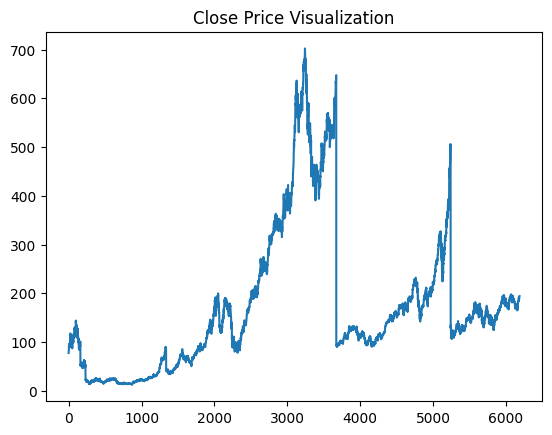

In [8]:
plt.title("Close Price Visualization")
plt.plot(combined_df['AAPL_4. close'], label='APPLE')

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

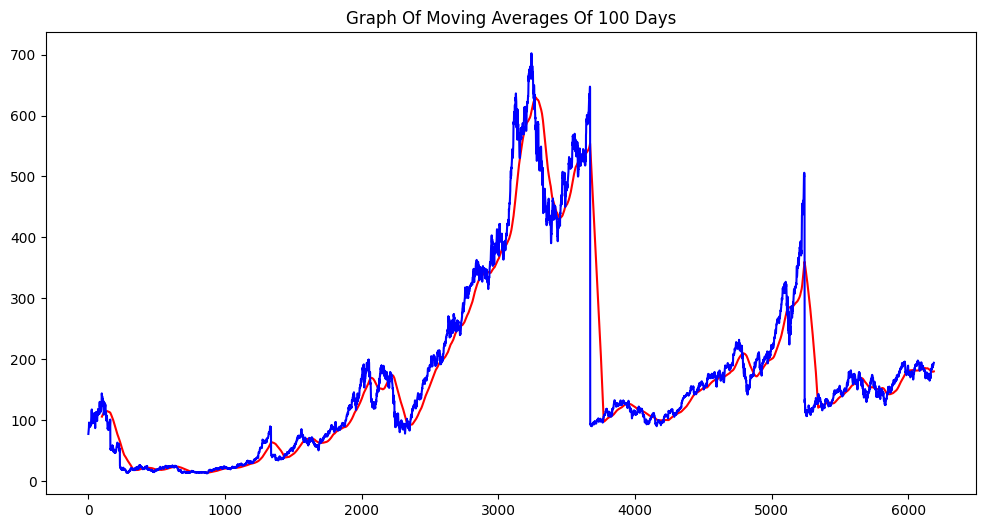

In [9]:
ma100 = combined_df['AAPL_4. close'].rolling(100).mean()
plt.figure(figsize = (12,6))
plt.plot(ma100, 'r')
plt.plot(combined_df['AAPL_4. close'], 'b')
plt.title('Graph Of Moving Averages Of 100 Days')

Text(0.5, 1.0, 'Graph Of Moving Averages Of 200 Days')

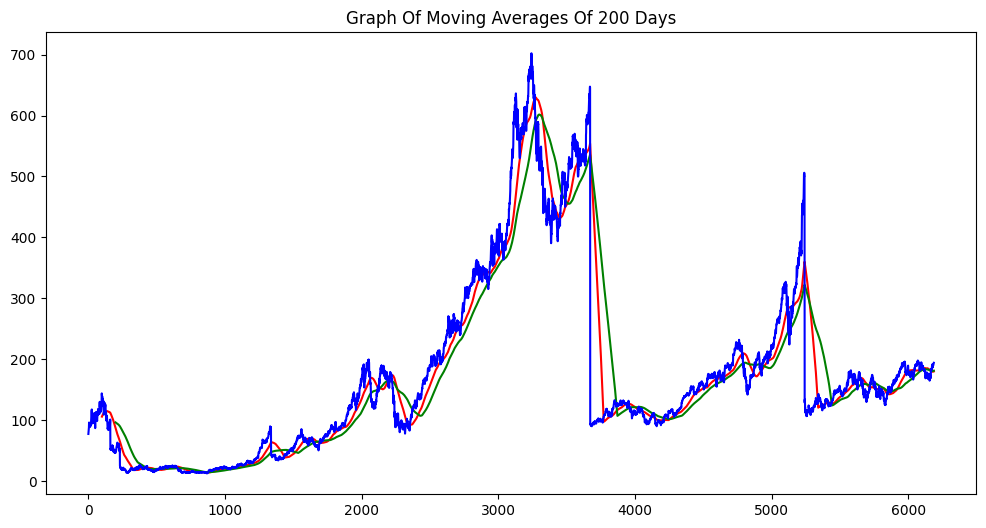

In [10]:
ma200 = combined_df['AAPL_4. close'].rolling(200).mean()
plt.figure(figsize = (12,6))
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.plot(combined_df['AAPL_4. close'], 'b')
plt.title('Graph Of Moving Averages Of 200 Days')

In [11]:
combined_df.to_csv("data/combined1.csv")

In [12]:
print(combined_df.tail())


            Date  AAPL_1. open  AAPL_4. close     MSFT   GOOGL    AMZN  \
6182  1716940800       189.610         190.29  425.690  175.43  181.70   
6183  1717027200       190.760         191.29  424.300  175.20  181.31   
6184  1717113600       191.440         192.25  416.750  171.86  178.30   
6185  1717372800       192.900         194.03  415.525  172.54  177.70   
6186  1717459200       194.635         194.35  412.430  173.28  177.64   

        META     NVDA    SSNLF   SONY  ...      GE     HON     MMM     CAT  \
6182  474.66  1130.50  40.5999  78.99  ...  166.60  197.83   97.80  345.00   
6183  471.67  1146.50  40.5999  80.48  ...  163.48  197.80   97.69  338.47   
6184  465.80  1125.20  40.5999  81.75  ...  164.29  200.33   98.06  339.34   
6185  470.86  1136.21  40.5999  83.13  ...  166.12  203.82  100.37  340.87   
6186  477.00  1157.16  40.5999  85.35  ...  161.00  201.06   99.00  328.71   

          XOM     CVX    NEE     DUK     SLB  Original_Date  
6182  114.525  158.02  7

HANDLING MISSING DATA

In [13]:
combined_df.isna().sum()

Date                0
AAPL_1. open        0
AAPL_4. close       0
MSFT                0
GOOGL            1205
AMZN                0
META             3157
NVDA                0
SSNLF             811
SONY                0
BBY                 0
COST                0
WMT                 0
INTC                0
AMD                 0
TXN                 0
QCOM                0
AVGO             2455
T                   0
VZ                  0
TMUS             1875
CSCO                0
CRM              1165
ADBE                0
ORCL                0
NOW              3186
V                2106
MA               1650
PYPL             3952
SQ               4039
TSLA             2680
GM               2780
F                   0
NIO              4746
RIVN             5543
JNJ                 0
PFE                 0
MRNA             4806
GILD                0
AMGN                0
BA                  0
GE                  0
HON                 0
MMM                 0
CAT                 0
XOM       

In [14]:
#delete columns with missing values 
combined_df = combined_df.dropna(axis=1)
combined_df.isna().sum()

Date             0
AAPL_1. open     0
AAPL_4. close    0
MSFT             0
AMZN             0
NVDA             0
SONY             0
BBY              0
COST             0
WMT              0
INTC             0
AMD              0
TXN              0
QCOM             0
T                0
VZ               0
CSCO             0
ADBE             0
ORCL             0
F                0
JNJ              0
PFE              0
GILD             0
AMGN             0
BA               0
GE               0
HON              0
MMM              0
CAT              0
XOM              0
CVX              0
NEE              0
DUK              0
SLB              0
Original_Date    0
dtype: int64

SPLITTING THE DATA INTO TRAINING AND TESTING SETS

In [15]:
data = combined_df
train = pd.DataFrame(data[0:int(len(data)*0.80)])
test = pd.DataFrame(data[int(len(data)*0.80): int(len(data))])

print(train.shape)
print(test.shape)

(4949, 35)
(1238, 35)


In [16]:
train_close = train[['AAPL_4. close']].values
test_close = test[['AAPL_4. close']].values

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_close)
data_training_array = scaler.fit_transform(train_close)
data_training_array


array([[0.09361665],
       [0.09743389],
       [0.09924816],
       ...,
       [0.27349125],
       [0.27520392],
       [0.27764231]])

In [18]:
x_train = []
y_train = [] 

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [19]:
x_train.shape


(4849, 100, 1)

TRAINING THE MODEL

FIRST MODEL

In [20]:
# 5. Build the LSTM model
input_shape = (x_train.shape[1], 1)

model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=input_shape))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))


SECOND MODEL

In [21]:
model2 = Sequential()

model2.add(LSTM(60, return_sequences=True, activation='tanh', input_shape=input_shape))
model2.add(Dropout(0.1))

model2.add(LSTM(80, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.1))

model2.add(LSTM(100, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.1))

model2.add(LSTM(80, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.1))

model2.add(LSTM(40, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.1))

model2.add(Dense(1))


In [22]:

model3 = Sequential()
model3.add(LSTM(units = 50, activation = 'tanh', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model3.add(Dropout(0.2))


model3.add(LSTM(units = 60, activation = 'tanh', return_sequences=True))
model3.add(Dropout(0.3))


model3.add(LSTM(units = 80, activation = 'tanh', return_sequences=True))
model3.add(Dropout(0.4))


model3.add(LSTM(units = 120, activation = 'tanh'))
model3.add(Dropout(0.5))

model3.add(Dense(units = 1))


In [23]:
model4 = Sequential()
model4.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
model4.add(LayerNormalization())
model4.add(Dropout(0.2))

model4.add(Bidirectional(LSTM(50, return_sequences=True)))
model4.add(LayerNormalization())
model4.add(Dropout(0.2))

model4.add(Bidirectional(LSTM(50, return_sequences=True)))
model4.add(LayerNormalization())
model4.add(Dropout(0.2))

model4.add(Dense(25, activation='tanh'))
model4.add(Dropout(0.2))
model4.add(Dense(1))


In [24]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['MAE'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 lstm (LSTM)                 (None, 100, 80)           26240     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           26200     
                                                                 
 lstm_2 (LSTM)               (None, 40)                14560     
                                                                 
 dense (Dense)               (None, 25)                1025      
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 68,701
Trainable params: 68,701
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile(optimizer='adam', loss='mean_squared_error',metrics = ['MAE'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 60)           14880     
                                                                 
 dropout (Dropout)           (None, 100, 60)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_1 (Dropout)         (None, 100, 80)           0         


                                                                 
 lstm_5 (LSTM)               (None, 100, 100)          72400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)           57920     
                                                                 
 dropout_3 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100, 40)           19360     
                                                                 
 dropout_4 (Dropout)         (None, 100, 40)           0         
                                                                 
 dense_3 (Dense)             (None, 100, 1)            41        
                                                                 
Total para

In [26]:
model3.compile(optimizer='adam', loss='mean_squared_error',metrics = ['MAE'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_5 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_6 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_7 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

In [27]:
model4.compile(optimizer='adam', loss='mean_squared_error',metrics = ['MAE'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 100)         20800     
 l)                                                              
                                                                 
 layer_normalization (LayerN  (None, 100, 100)         200       
 ormalization)                                                   
                                                                 
 dropout_9 (Dropout)         (None, 100, 100)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 100)         60400     
 nal)                                                            
                                                                 
 layer_normalization_1 (Laye  (None, 100, 100)         200       
 rNormalization)                                      

In [28]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

Epoch 1/1000
152/152 [==============================] - 29s 65ms/step - loss: 0.0042 - MAE: 0.0290
Epoch 2/1000
152/152 [==============================] - 11s 70ms/step - loss: 0.0013 - MAE: 0.0176
Epoch 3/1000
152/152 [==============================] - 8s 50ms/step - loss: 9.6946e-04 - MAE: 0.0140
Epoch 4/1000
152/152 [==============================] - 11s 76ms/step - loss: 9.2071e-04 - MAE: 0.0153
Epoch 5/1000
152/152 [==============================] - 10s 68ms/step - loss: 7.0303e-04 - MAE: 0.0120
Epoch 6/1000
152/152 [==============================] - 10s 66ms/step - loss: 5.7673e-04 - MAE: 0.0110
Epoch 7/1000
152/152 [==============================] - 10s 67ms/step - loss: 6.0640e-04 - MAE: 0.0122
Epoch 8/1000
152/152 [==============================] - 10s 63ms/step - loss: 6.0830e-04 - MAE: 0.0124
Epoch 9/1000
152/152 [==============================] - 9s 56ms/step - loss: 5.3020e-04 - MAE: 0.0113
Epoch 10/1000
152/152 [==============================] - 12s 82ms/step - loss: 4.12

In [29]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model2.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

Epoch 1/1000
152/152 [==============================] - 45s 119ms/step - loss: 0.0586 - MAE: 0.1800
Epoch 2/1000
152/152 [==============================] - 14s 92ms/step - loss: 0.0568 - MAE: 0.1797
Epoch 3/1000
152/152 [==============================] - 21s 136ms/step - loss: 0.0564 - MAE: 0.1785
Epoch 4/1000
152/152 [==============================] - 20s 133ms/step - loss: 0.0567 - MAE: 0.1795
Epoch 5/1000
152/152 [==============================] - 14s 94ms/step - loss: 0.0564 - MAE: 0.1793
Epoch 6/1000
152/152 [==============================] - 22s 142ms/step - loss: 0.0562 - MAE: 0.1786
Epoch 7/1000
152/152 [==============================] - 14s 91ms/step - loss: 0.0564 - MAE: 0.1793
Epoch 8/1000
152/152 [==============================] - 16s 103ms/step - loss: 0.0562 - MAE: 0.1788
Epoch 9/1000
152/152 [==============================] - 15s 97ms/step - loss: 0.0562 - MAE: 0.1794
Epoch 10/1000
152/152 [==============================] - 19s 125ms/step - loss: 0.0562 - MAE: 0.1788
Epo

In [30]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model3.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

Epoch 1/1000
152/152 [==============================] - 30s 84ms/step - loss: 0.0065 - MAE: 0.0436
Epoch 2/1000
152/152 [==============================] - 16s 104ms/step - loss: 0.0035 - MAE: 0.0326
Epoch 3/1000
152/152 [==============================] - 19s 122ms/step - loss: 0.0032 - MAE: 0.0316
Epoch 4/1000
152/152 [==============================] - 11s 72ms/step - loss: 0.0029 - MAE: 0.0306
Epoch 5/1000
152/152 [==============================] - 17s 112ms/step - loss: 0.0025 - MAE: 0.0285
Epoch 6/1000
152/152 [==============================] - 13s 86ms/step - loss: 0.0024 - MAE: 0.0264
Epoch 7/1000
152/152 [==============================] - 14s 92ms/step - loss: 0.0021 - MAE: 0.0257
Epoch 8/1000
152/152 [==============================] - 13s 83ms/step - loss: 0.0021 - MAE: 0.0250
Epoch 9/1000
152/152 [==============================] - 22s 144ms/step - loss: 0.0021 - MAE: 0.0256
Epoch 10/1000
152/152 [==============================] - 19s 126ms/step - loss: 0.0022 - MAE: 0.0264
Epoc

In [31]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model4.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

Epoch 1/1000
152/152 [==============================] - 53s 88ms/step - loss: 0.3003 - MAE: 0.4262
Epoch 2/1000
152/152 [==============================] - 15s 96ms/step - loss: 0.1235 - MAE: 0.2756
Epoch 3/1000
152/152 [==============================] - 15s 100ms/step - loss: 0.0900 - MAE: 0.2339
Epoch 4/1000
152/152 [==============================] - 16s 104ms/step - loss: 0.0778 - MAE: 0.2155
Epoch 5/1000
152/152 [==============================] - 15s 100ms/step - loss: 0.0703 - MAE: 0.2042
Epoch 6/1000
152/152 [==============================] - 14s 95ms/step - loss: 0.0658 - MAE: 0.1964
Epoch 7/1000
152/152 [==============================] - 18s 115ms/step - loss: 0.0629 - MAE: 0.1913
Epoch 8/1000
152/152 [==============================] - 14s 95ms/step - loss: 0.0618 - MAE: 0.1891
Epoch 9/1000
152/152 [==============================] - 19s 126ms/step - loss: 0.0598 - MAE: 0.1854
Epoch 10/1000
152/152 [==============================] - 14s 90ms/step - loss: 0.0591 - MAE: 0.1843
Epoc

In [32]:
model.save('keras_model.h5')
model2.save('keras_model2.h5')
model3.save('keras_model3.h5')
model4.save('keras_model4.h5')

In [33]:
test_close.shape
test_close

array([[204.23],
       [200.02],
       [201.24],
       ...,
       [192.25],
       [194.03],
       [194.35]])

In [34]:
past_100_days = pd.DataFrame(train_close[-100:])
test_df = pd.DataFrame(test_close)
final_df = pd.concat([past_100_days, test_df], ignore_index=True)
final_df = scaler.transform(final_df)


In [35]:
input_data = scaler.fit_transform(final_df)
input_data

input_data.shape

(1338, 1)

In [36]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)


(1238, 100, 1)
(1238,)


PREDICTIONS WITH THE FIRST MODEL

39/39 [==============================] - 2s 17ms/step


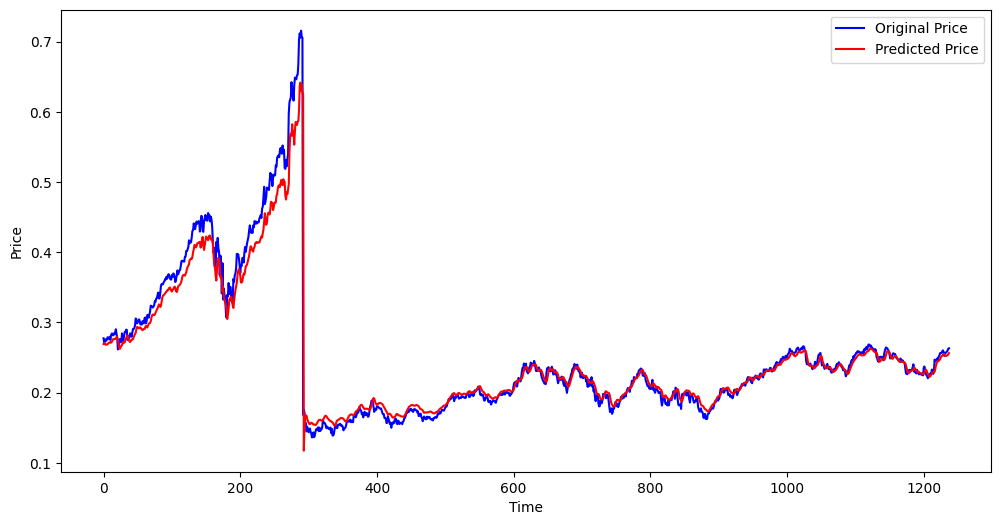

In [37]:
y_pred = model.predict(x_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Mean Absolute Error is: ", mae)
print("The Mean Squared Error is: ", mse)

The Mean Absolute Error is:  0.010772892859637768
The Mean Squared Error is:  0.0004444719185371556


39/39 [==============================] - 1s 26ms/step


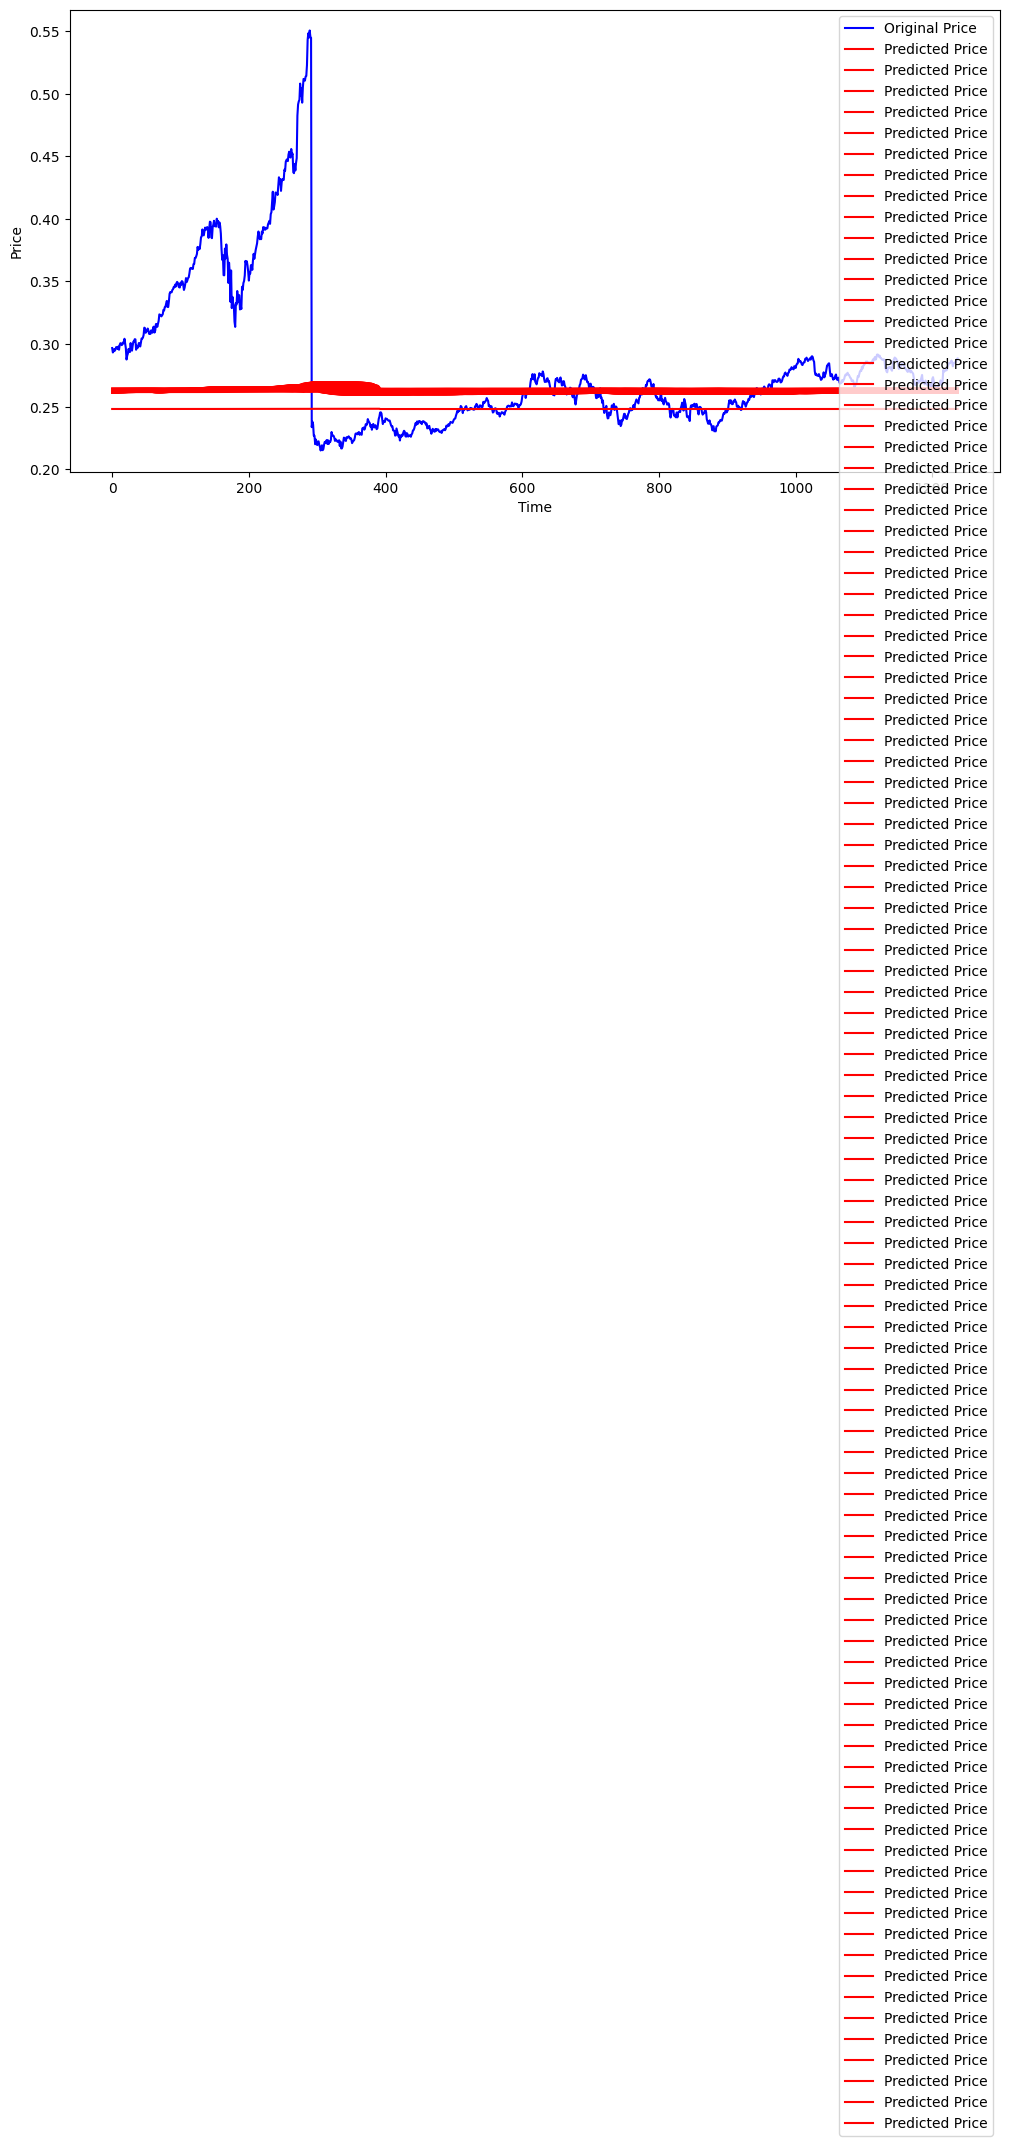

In [43]:
y_pred2 = model2.predict(x_test)
y_pred2 = y_pred2.reshape(y_pred2.shape[0], y_pred2.shape[1])

# scale_factor = 1/scaler.scale_
y_pred2 = scaler.inverse_transform(y_pred2)
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred2, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
print("The Mean Absolute Error is: ", mae)
print("The Mean Squared Error is: ", mse)

39/39 [==============================] - 1s 21ms/step


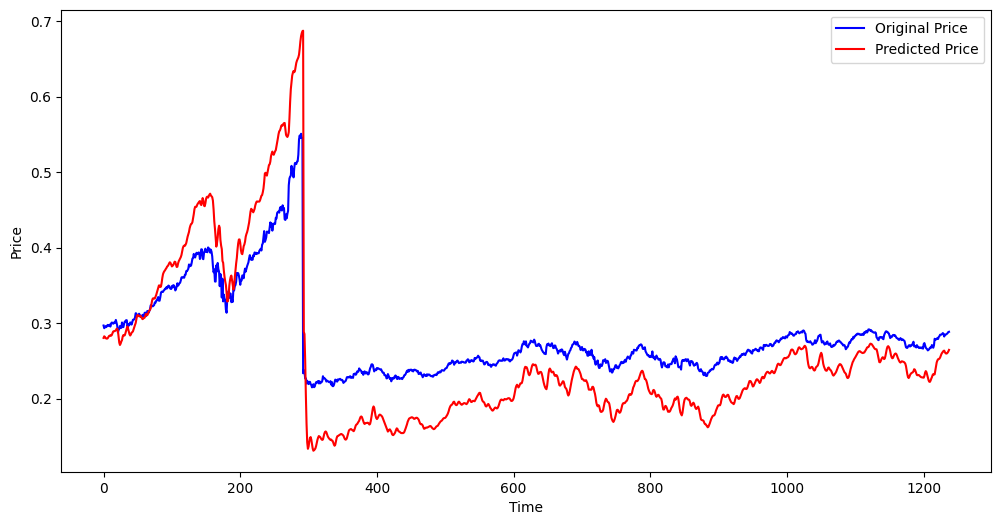

In [44]:
y_pred3 = model3.predict(x_test)

y_pred3 = scaler.inverse_transform(y_pred3)

plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred3, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred3)
mse = mean_squared_error(y_test, y_pred3)
print("The Mean Absolute Error is: ", mae)
print("The Mean Squared Error is: ", mse)

In [42]:
y_pred4 = model4.predict(x_test)

y_pred4 = scaler.inverse_transform(y_pred4)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred4, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

39/39 [==============================] - 4s 37ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred4)
mse = mean_squared_error(y_test, y_pred4)
print("The Mean Absolute Error is: ", mae)
print("The Mean Squared Error is: ", mse)